In [1]:
from aeon.datasets import load_classification
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from laplace_hdc_helper import load_dataset
from laplace_hdc_classifier_1d import train_hdc_classifier, test_hdc_classifier
from laplace_hdc_encoder_1d import hdc_encoder
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from scipy.io import savemat, loadmat


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_name = 'WalkingSittingStanding'
hyperdim = 15_000

In [3]:
# Load dataset
X_train, y_train, metadata = load_classification(dataset_name, return_metadata=True, split='train')
X_test, y_test = load_classification(dataset_name, split='test')
if X_train.shape[0] < 200:
    if X_test.shape[0] >= 200:
        train_size = (X_train.shape[0] + X_test.shape[0]) * 3/4
        x, y = load_classification(dataset_name)
        X_train, y_train = x[:train_size, :], y[:train_size]
        X_test, y_test = x[train_size:, :], y[train_size:]

In [4]:
input_channels = 1
if X_train.ndim == 3:
    input_channels = X_train.shape[1]
seq_length = X_train.shape[-1]
if y_train.dtype == object or isinstance(y_train[0], str):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

In [5]:
X_train.shape

(7352, 3, 206)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, seq_length))
X_test_scaled = scaler.transform(X_test.reshape(-1, seq_length))

if input_channels == 1:
    X_min = X_train_scaled.min(axis=0)
    X_max = X_train_scaled.max(axis=0)
    
    denom = (X_max - X_min)
    denom[denom == 0] = 1   # avoid division by zero
    
    X_train_norm = (X_train_scaled - X_min) / denom
    X_test_norm  = (X_test_scaled  - X_min) / denom
    
    # Optional: clip to [0,1] just in case
    X_train_norm = np.clip(X_train_norm, 0, 1)
    X_test_norm  = np.clip(X_test_norm, 0, 1)
    X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32).unsqueeze(1).to(device)
    X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).unsqueeze(1).to(device)
else:
    X_min = X_train.min(axis=0)
    X_max = X_train.max(axis=0)
    
    denom = (X_max - X_min)
    denom[denom == 0] = 1   # avoid division by zero
    
    X_train_norm = (X_train - X_min) / denom
    X_test_norm  = (X_test  - X_min) / denom
    
    # Optional: clip to [0,1] just in case
    X_train_norm = np.clip(X_train_norm, 0, 1)
    X_test_norm  = np.clip(X_test_norm, 0, 1)
    # Multichannel → keep original channels
    X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).to(device)

    

In [7]:
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

num_classes = len(np.unique(y_train))

In [8]:
torch.min(X_test_tensor), torch.max(X_test_tensor), np.unique(y_train)

(tensor(0., device='cuda:0'),
 tensor(1., device='cuda:0'),
 array([0, 1, 2, 3, 4, 5]))

lambda = 0.06255343556404114
618


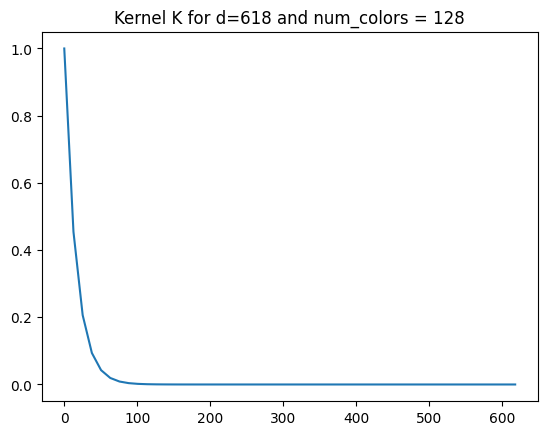

In [9]:
# Determining Lambda from random 1000 samples
bandwidth_parameter = 3 # bandwidth parameter
encoder_mode = 'shift_1d'
classifier_mode="float_sgd"
batch_size = 1024
num_colors = 128

X,  _ = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
X = X.reshape(X.shape[0],-1).cpu()

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())
lmd = bandwidth_parameter/a
print(f"lambda = {lmd}")

# Define the local kernel
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

# Visualize the global kernel
d = train_data[0][0].squeeze().numel()
print(d)
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

In [10]:
import torch
from torch.utils.data import TensorDataset
from typing import Optional   # ← add this

@torch.no_grad()
def flip_bits_bool(H: torch.BoolTensor,
                   perc: float,
                   *,
                   inplace: bool = True,
                   ) -> torch.BoolTensor:
    """
    Flip exactly round(perc·D) bits in each row of a boolean tensor H.

    Works on a flattened (M, D) view, then reshapes back to H’s shape.
    """
    if perc <= 0.0:
        return H if inplace else H.clone()

    flat = H.view(H.shape[0], -1)        # (M, D)
    M, D = flat.shape
    k = int(round(perc * D))
    if k == 0:
        return H if inplace else H.clone()

    out = flat if inplace else flat.clone()
    rows = torch.arange(M, device=H.device).repeat_interleave(k)

    cols = torch.cat([
        torch.multinomial(torch.ones(D, device=H.device),
                          k, replacement=False)
        for _ in range(M)
    ])

    out[rows, cols] = ~out[rows, cols]   # toggle bits (True ↔ False)
    return out.view_as(H)



def corrupt_dataset(dataset: TensorDataset, perc: float):
    """
    Return a new TensorDataset whose data tensor has been bit-flipped.
    Labels are untouched.
    """
    data, labels = dataset.tensors
    data_flipped = flip_bits_bool(data.clone(), perc)
    return TensorDataset(data_flipped, labels)


In [11]:
num_workers = 0
pin_memory=False
n_splits = 20
split_size = len(test_data) // n_splits
percs = np.arange(0.0, 0.51, 0.05)
accuracies = np.zeros((len(percs), n_splits))
for i, perc in enumerate(percs):
    # Train
    for split_idx in tqdm(range(n_splits)):
        indices = list(range(len(test_data)))
        np.random.shuffle(indices)  # or random.shuffle(indices)
        start_idx = split_idx * split_size
        end_idx = start_idx + split_size
        split_indices = indices[start_idx:end_idx]
        split_subset = Subset(test_data, split_indices)
        split_loader = torch.utils.data.DataLoader(split_subset, batch_size=10, shuffle=False,
                                                   num_workers=num_workers, pin_memory=pin_memory)
        encoder = hdc_encoder(d, hyperdim, kernel, encoder_mode)
        train_hdc = encoder.encode(train_loader)
        train_loader_hdc = DataLoader(train_hdc,batch_size=10,shuffle=True,num_workers=0,pin_memory=False)
        model = train_hdc_classifier(train_loader_hdc, num_classes, mode=classifier_mode, epochs=10)
        # Test
        split_hdc = encoder.encode(split_loader)
        split_hdc = corrupt_dataset(split_hdc, perc=perc)
        split_loader_hdc = DataLoader(
            split_hdc,
            batch_size=64,
            shuffle=True,
            num_workers=0,
            pin_memory=False
        )
        accuracies[i, split_idx] = test_hdc_classifier(model, split_loader_hdc)*100
    print(f'Flipping Percentage: {perc} Finished. Average Accuracy over {n_splits} rounds: {np.mean(accuracies[i])}, std: {np.std(accuracies[i])}')


100%|██████████| 20/20 [06:19<00:00, 19.00s/it]


Flipping Percentage: 0.0 Finished. Average Accuracy over 20 rounds: 77.17687074829931, std: 2.219762394423089


100%|██████████| 20/20 [06:17<00:00, 18.89s/it]


Flipping Percentage: 0.05 Finished. Average Accuracy over 20 rounds: 77.0748299319728, std: 2.670447132842246


100%|██████████| 20/20 [06:19<00:00, 18.99s/it]


Flipping Percentage: 0.1 Finished. Average Accuracy over 20 rounds: 75.74829931972789, std: 3.7647699167760833


100%|██████████| 20/20 [06:18<00:00, 18.91s/it]


Flipping Percentage: 0.15000000000000002 Finished. Average Accuracy over 20 rounds: 75.98639455782313, std: 3.2203538445019375


100%|██████████| 20/20 [06:22<00:00, 19.10s/it]


Flipping Percentage: 0.2 Finished. Average Accuracy over 20 rounds: 73.87755102040816, std: 3.258212248932802


100%|██████████| 20/20 [06:19<00:00, 18.99s/it]


Flipping Percentage: 0.25 Finished. Average Accuracy over 20 rounds: 73.19727891156462, std: 3.200895334971048


100%|██████████| 20/20 [06:23<00:00, 19.19s/it]


Flipping Percentage: 0.30000000000000004 Finished. Average Accuracy over 20 rounds: 72.24489795918367, std: 3.785150406324778


100%|██████████| 20/20 [06:19<00:00, 18.97s/it]


Flipping Percentage: 0.35000000000000003 Finished. Average Accuracy over 20 rounds: 71.19047619047619, std: 4.325348531454138


100%|██████████| 20/20 [06:20<00:00, 19.05s/it]


Flipping Percentage: 0.4 Finished. Average Accuracy over 20 rounds: 64.79591836734694, std: 3.6435859329300238


100%|██████████| 20/20 [06:20<00:00, 19.02s/it]


Flipping Percentage: 0.45 Finished. Average Accuracy over 20 rounds: 48.91156462585034, std: 2.9722520101977516


100%|██████████| 20/20 [06:18<00:00, 18.95s/it]

Flipping Percentage: 0.5 Finished. Average Accuracy over 20 rounds: 17.346938775510203, std: 2.94566463872258


In [12]:
np.mean(accuracies, axis=1)

array([77.17687075, 77.07482993, 75.74829932, 75.98639456, 73.87755102,
       73.19727891, 72.24489796, 71.19047619, 64.79591837, 48.91156463,
       17.34693878])

In [13]:
savemat(f'{dataset_name}_LaplaceHDC.mat', {f'{dataset_name}_LaplaceHDC': accuracies})